# CNN + MNIST with Simple Adversarial Attack (FGSM)

closely follows CNN MNIST demo code

## 1. Import Statements

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# for reproducibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

print(tf.__version__)

2.20.0


## 2. Load and Preprocess MNIST Data

In [40]:
# load MNIST from Keras datasets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# add channel dimension and scale to [0, 1]
X_train = (X_train[..., None].astype("float32")) / 255.0
X_test  = (X_test[..., None].astype("float32"))  / 255.0

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (60000, 28, 28, 1) (60000,)
Test:  (10000, 28, 28, 1) (10000,)


### 2.1 Visualize a Few Training Images

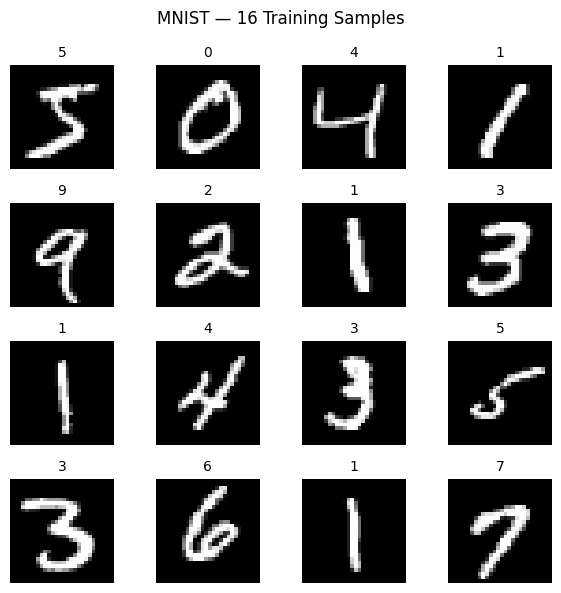

In [41]:
imgs   = X_train[:16, :, :, 0]  # (16, 28, 28)
labels = y_train[:16]

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i], cmap="gray")
    ax.set_title(str(int(labels[i])), fontsize=10)
    ax.axis("off")
plt.suptitle("MNIST — 16 Training Samples")
plt.tight_layout()
plt.show()

## 3. Build CNN Model (Keras Sequential)

In [42]:
model = keras.Sequential([
    layers.Input(shape=(28, 28, 1)),

    # Block 1
    layers.Conv2D(32, kernel_size=3, padding='same', strides=1, use_bias=False),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2, strides=2),  # 28x28 -> 14x14

    # Block 2
    layers.Conv2D(64, kernel_size=3, padding='same', strides=1, use_bias=False),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2, strides=2),  # 14x14 -> 7x7

    # Head
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-8),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,474 (197.16 KB)

 Trainable params: 50,282 (196.41 KB)

 Non-trainable params: 192 (768.00 B)

## 4. Train the CNN on MNIST

In [43]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=128,
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9359 - loss: 0.2083 - val_accuracy: 0.8431 - val_loss: 0.5288
Epoch 2/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9795 - loss: 0.0637 - val_accuracy: 0.9847 - val_loss: 0.0528
Epoch 3/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9852 - loss: 0.0479 - val_accuracy: 0.9880 - val_loss: 0.0424
Test accuracy: 0.9883


## 5. Classification Report and Confusion Matrix

In [44]:
# predicted probabilities and labels
y_prob = model.predict(X_test, verbose=1)
y_pred = y_prob.argmax(axis=1)

print(classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## 6. Implementation: Simple FGSM Adversarial Attack

Implementation of Fast Gradient Sign Method (FGSM) attack. Math (for one image) is from the following source:

Goodfellow, I. J., Shlens, J., & Szegedy, C. (2014). Explaining and harnessing adversarial examples. https://arxiv.org/abs/1412.6572

$$x_{adv} = x + \epsilon \cdot \text{sign}(\nabla_x L(x, y))$$

Algorithm:

1. Select one correctly classified test image.
2. Compute the gradient of the loss with respect to the input.
3. Add a small perturbation in the direction of the sign of this gradient.
4. Compare model predictions on the original and adversarial images.

In [ ]:
def fgsm_attack(model, x, y_true, epsilon=0.1):
    x_inp = tf.convert_to_tensor(x[None, ...])  # add batch dim
    y_inp = tf.convert_to_tensor([y_true])

    #track how changing the input pixels affects the loss
    with tf.GradientTape() as tape:
        tape.watch(x_inp)
        preds = model(x_inp, training=False)
        loss = keras.losses.sparse_categorical_crossentropy(y_inp, preds)

    # gradient of loss w.r.t. input
    grad = tape.gradient(loss, x_inp)
    signed_grad = tf.sign(grad)

    #Brighter if sign is +1
    #Darker if sign is −1
    x_adv = x_inp + epsilon * signed_grad
    
    #Stop illegal values like negative pixels or >1 brightness.
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    
    return x_adv[0].numpy()

def fgsm_batch(model, x_batch, y_batch, epsilon=0.1):
    x_inp = tf.convert_to_tensor(x_batch)
    y_inp = tf.convert_to_tensor(y_batch)

    with tf.GradientTape() as tape:
        tape.watch(x_inp)
        preds = model(x_inp, training=False)
        loss = keras.losses.sparse_categorical_crossentropy(y_inp, preds)

    grad = tape.gradient(loss, x_inp)
    signed_grad = tf.sign(grad)
    x_adv = x_inp + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv


# choose a test example that is correctly classified
idx = 0
x0 = X_test[idx]
y0 = int(y_test[idx])

pred0 = int(model.predict(x0[None, ...]).argmax(axis=1)[0])
print("True label:", y0)
print("Model prediction (original):", pred0)

epsilon = .3
x_adv = fgsm_attack(model, x0, y0, epsilon=epsilon)

pred_adv = int(model.predict(x_adv[None, ...]).argmax(axis=1)[0])
print("Model prediction (adversarial):", pred_adv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
True label: 7
Model prediction (original): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Model prediction (adversarial): 3


### 6.1 Visualize Original vs Adversarial Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


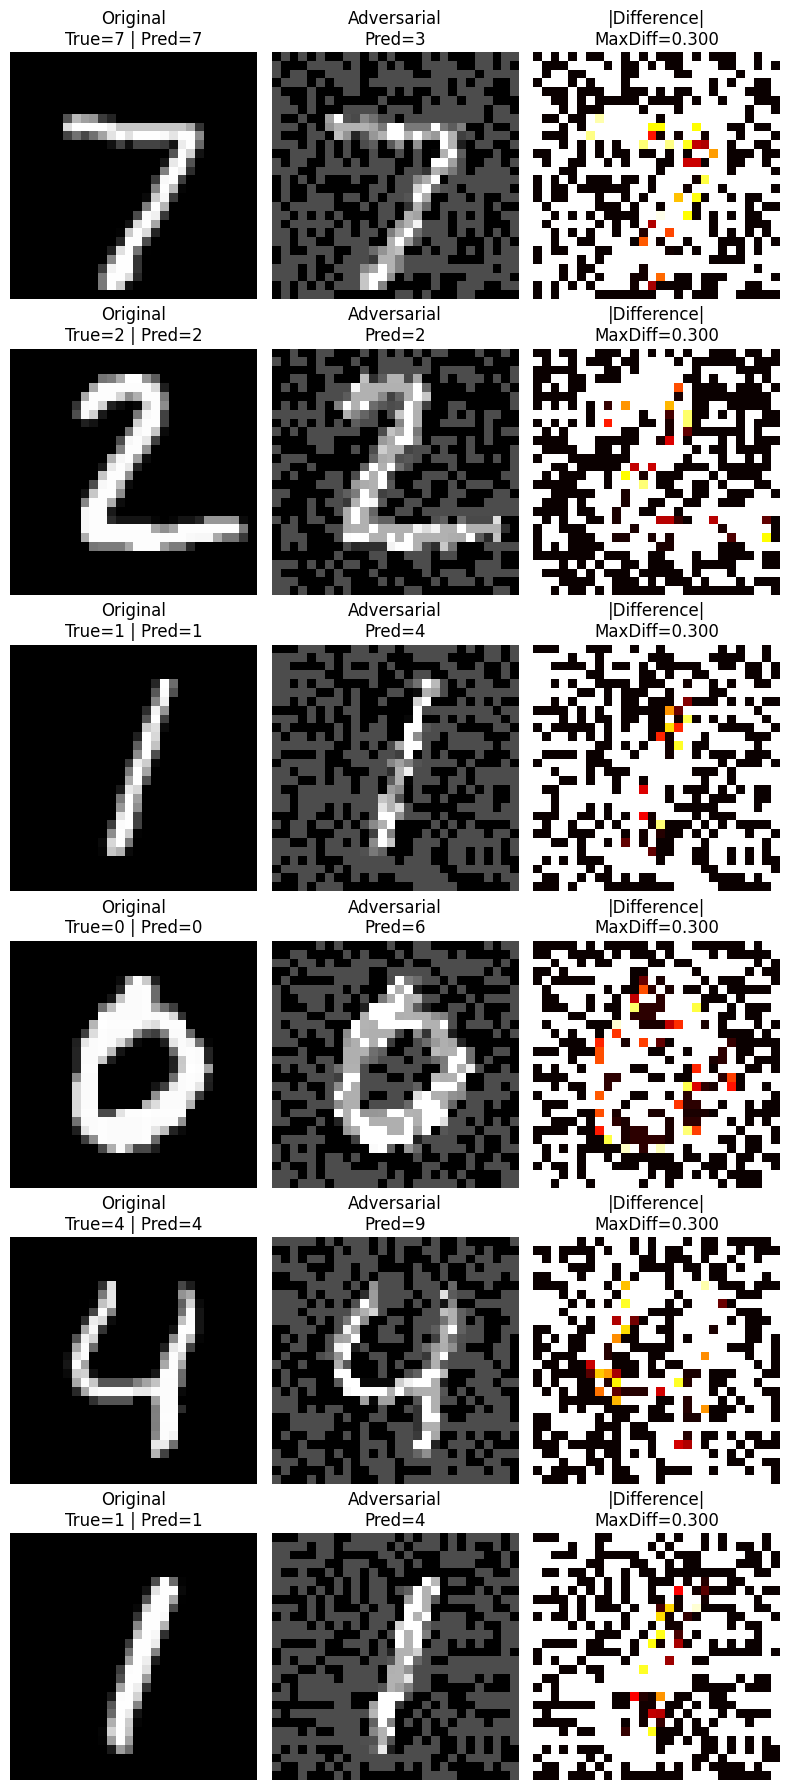

In [46]:
num_samples = 6

fig, axes = plt.subplots(num_samples, 3, figsize=(8, 3 * num_samples))

for i in range(num_samples):
    x = X_test[i]
    y_true = int(y_test[i])
    
    # Generate adversarial sample
    x_adv = fgsm_attack(model, x, y_true, epsilon=epsilon)
    
    # Model predictions
    pred_orig = int(model.predict(x[None, ...]).argmax(axis=1)[0])
    pred_adv = int(model.predict(x_adv[None, ...]).argmax(axis=1)[0])
    
    # Difference map
    diff = np.abs(x_adv - x)
    
    # ORIGINAL
    axes[i, 0].imshow(x[:, :, 0], cmap='gray', vmin=0, vmax=1)
    axes[i, 0].set_title(f"Original\nTrue={y_true} | Pred={pred_orig}")
    axes[i, 0].axis('off')
    
    # ADVERSARIAL
    axes[i, 1].imshow(x_adv[:, :, 0], cmap='gray', vmin=0, vmax=1)
    axes[i, 1].set_title(f"Adversarial\nPred={pred_adv}")
    axes[i, 1].axis('off')
    
    # DIFFERENCE
    axes[i, 2].imshow(diff[:, :, 0], cmap='hot')
    axes[i, 2].set_title(f"|Difference|\nMaxDiff={diff.max():.3f}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


## 7. Adversarial Training

In [47]:
def make_cnn_model():
    m = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),

        # Block 1
        layers.Conv2D(32, kernel_size=3, padding='same', strides=1, use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=2, strides=2),

        # Block 2
        layers.Conv2D(64, kernel_size=3, padding='same', strides=1, use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=2, strides=2),

        # Head
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.Dense(10, activation='softmax')
    ])

    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-8),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return m

adv_model = make_cnn_model()
adv_model.summary()


batch_size = 128
epochs = 3
epsilon_at = 0.3  # FGSM strength during adversarial training

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(10000).batch(batch_size)

loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = adv_model.optimizer  # from compile
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    for step, (x_batch, y_batch) in enumerate(train_ds):
        # Generate adversarial batch
        x_adv_batch = fgsm_batch(adv_model, x_batch, y_batch, epsilon=epsilon_at)

        # Combine clean + adversarial
        x_full = tf.concat([x_batch, x_adv_batch], axis=0)
        y_full = tf.concat([y_batch, y_batch], axis=0)

        with tf.GradientTape() as tape:
            logits = adv_model(x_full, training=True)
            loss_value = loss_fn(y_full, logits)

        grads = tape.gradient(loss_value, adv_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, adv_model.trainable_variables))

        train_acc_metric.update_state(y_full, logits)

        if (step + 1) % 100 == 0:
            print(
                f"Step {step + 1:4d} - "
                f"loss: {loss_value.numpy():.4f} - "
                f"acc: {train_acc_metric.result().numpy():.4f}"
            )

    # epoch end
    epoch_acc = train_acc_metric.result().numpy()
    print(f"Epoch {epoch + 1} training accuracy (clean+adv): {epoch_acc:.4f}")
    train_acc_metric.reset_state()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,474 (197.16 KB)

 Trainable params: 50,282 (196.41 KB)

 Non-trainable params: 192 (768.00 B)


Epoch 1/3
Step  100 - loss: 0.4055 - acc: 0.6703
Step  200 - loss: 0.1833 - acc: 0.7971
Step  300 - loss: 0.0692 - acc: 0.8535
Step  400 - loss: 0.0848 - acc: 0.8830
Epoch 1 training accuracy (clean+adv): 0.8951

Epoch 2/3
Step  100 - loss: 0.1789 - acc: 0.9496
Step  200 - loss: 0.1705 - acc: 0.9350
Step  300 - loss: 0.1332 - acc: 0.9414
Step  400 - loss: 0.2519 - acc: 0.9454
Epoch 2 training accuracy (clean+adv): 0.9477

Epoch 3/3
Step  100 - loss: 0.1974 - acc: 0.9682
Step  200 - loss: 0.0807 - acc: 0.9696
Step  300 - loss: 0.0207 - acc: 0.9747
Step  400 - loss: 0.0690 - acc: 0.9762
Epoch 3 training accuracy (clean+adv): 0.9779


In [48]:
# Generate adversarial test set using FGSM on adv_model
X_test_adv = fgsm_batch(adv_model, X_test, y_test, epsilon=epsilon_at)

loss_clean, acc_clean = adv_model.evaluate(X_test, y_test, verbose=0)
loss_adv, acc_adv = adv_model.evaluate(X_test_adv, y_test, verbose=0)

print(f"Clean test accuracy: {acc_clean:.4f}")
print(f"Adversarial FGSM (ε={epsilon_at}) test accuracy: {acc_adv:.4f}")


Clean test accuracy: 0.9849
Adversarial FGSM (ε=0.3) test accuracy: 0.9969


### 7.1 Visualize Original vs. AT

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


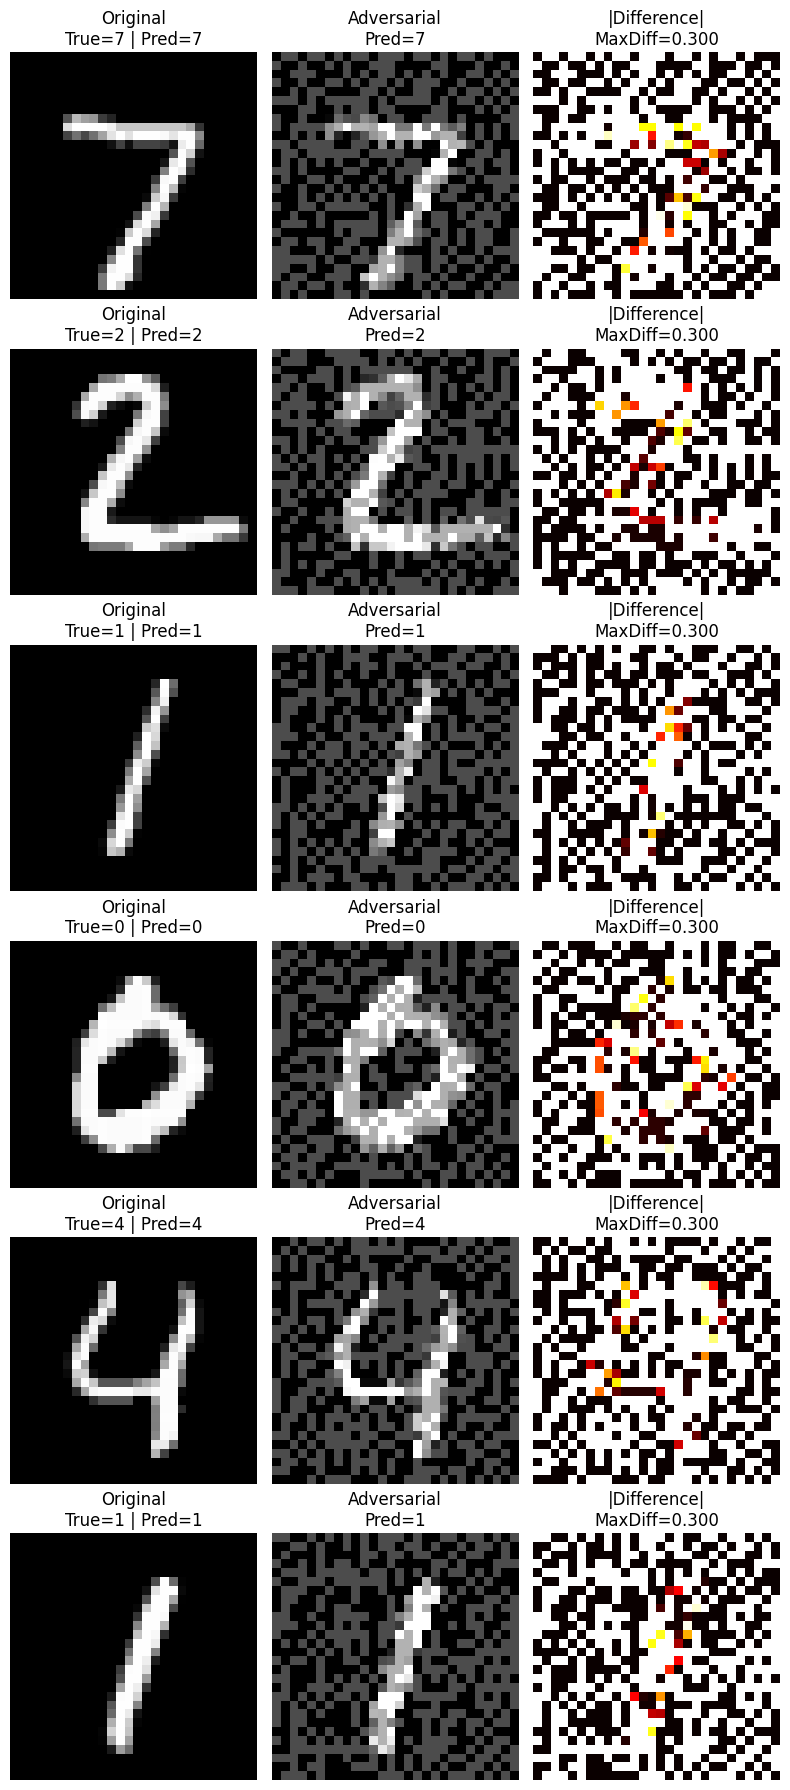

In [49]:
num_samples = 6  # adjust as needed

fig, axes = plt.subplots(num_samples, 3, figsize=(8, 3 * num_samples))

for i in range(num_samples):
    x_orig = X_test[i]
    x_adv = X_test_adv[i]
    y_true = int(y_test[i])

    pred_orig = int(adv_model.predict(x_orig[None, ...]).argmax(axis=1)[0])
    pred_adv  = int(adv_model.predict(x_adv[None, ...]).argmax(axis=1)[0])

    diff = np.abs(x_adv - x_orig)

    # ORIGINAL
    axes[i, 0].imshow(x_orig[:, :, 0], cmap='gray', vmin=0, vmax=1)
    axes[i, 0].set_title(f"Original\nTrue={y_true} | Pred={pred_orig}")
    axes[i, 0].axis("off")

    # ADVERSARIAL
    axes[i, 1].imshow(x_adv[:, :, 0], cmap='gray', vmin=0, vmax=1)
    axes[i, 1].set_title(f"Adversarial\nPred={pred_adv}")
    axes[i, 1].axis("off")

    # DIFFERENCE
    axes[i, 2].imshow(diff[:, :, 0], cmap="hot")
    axes[i, 2].set_title(f"|Difference|\nMaxDiff={diff.max():.3f}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()
